In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
import pandas as pd

# Load the Excel file (replace with the filename you uploaded)
df = pd.read_excel("/content/drive/MyDrive/Hackathon/Didul - Random forest/updated_with_prev_yield(Maha).xlsx")
df.head()

,Year,District,Sown(hect),Extent Harvested(hect),Yield(kg per hect),Total production(mt.),Season,Season_encoded,District_encoded
0,2004/2005,COLOMBO,4594.0,4592,3251.0,12687.0,Maha,0.0,4.0
1,2004/2005,GAMPAHA,10173.0,10170,3408.0,29460.0,Maha,0.0,6.0
2,2004/2005,KALUTARA,13642.0,13610,2865.0,35971.0,Maha,0.0,9.0
3,2004/2005,GALLE,14498.0,13943,3711.0,40494.0,Maha,0.0,5.0
4,2004/2005,MATARA,14862.0,14695,3785.0,43912.0,Maha,0.0,16.0


In [ ]:
# Sort so previous years come before current
df.sort_values(by=['District', 'Season', 'Year'], inplace=True)

# Add a new column: Previous year's average yield per district and season
df['Previous_Yield'] = df.groupby(['District', 'Season'])['Yield(kg per hect)'].shift(1)

In [ ]:
from google.colab import files

df.to_excel("updated_with_prev_yield(Maha).xlsx", index=False)
files.download("updated_with_prev_yield(Maha).xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Fix Year column by extracting first year as integer
# df['Year'] = df['Year'].apply(lambda x: int(str(x).split('/')[0]))

# Encode categorical columns
df['Season_encoded'] = LabelEncoder().fit_transform(df['Season'])
df['District_encoded'] = LabelEncoder().fit_transform(df['District'])

# Define features and target
# features = ['Year', 'Season_encoded', 'District_encoded', 'Yield(kg per hect)', 'Extent Harvested(hect)', 'Sown(hect)']
features = ['Year', 'Season_encoded', 'District_encoded', 'Sown(hect)', 'Previous_Yield']
target = 'Total production(mt.)'

In [ ]:
# Drop rows with missing values in features or target
df_clean = df.dropna(subset=features + [target])

X = df_clean[features]
y = df_clean[target]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install catboost scikit-learn

from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the base model
model = CatBoostRegressor(
    early_stopping_rounds=100,
    verbose=0,
    random_state=42
)

# Define the parameter grid
param_dist = {
    'iterations': [1000, 5000, 10000, 50000, 100000],
    'depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9, 12],
    'bagging_temperature': [0, 0.25, 0.5, 0.75, 1]
}

# Run randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_iter=20,  # number of combinations to try
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

print("Best Parameters:")
print(random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Train model
!pip install lightgbm catboost

from catboost import CatBoostRegressor

# model_extent = CatBoostRegressor(
#     iterations=100000,       # high upper limit
#     early_stopping_rounds=100,  # stop if no improvement for 100 rounds
#     verbose=100,
#     random_state=42
# )

model_extent = CatBoostRegressor(
    iterations=13500,
    depth=12,
    learning_rate=0.2,
    l2_leaf_reg=12,
    bagging_temperature=1,
    early_stopping_rounds=100,
    verbose=100,
    random_state=42
)

# !pip install lightgb

# from lightgbm import LGBMRegressor

# model_extent = LGBMRegressor(
#    n_estimators=100,
#    max_depth=10,
#    learning_rate=0.1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    random_state=42
# )

# !pip install xgboost

# from xgboost import XGBRegressor

# model_extent = XGBRegressor(
#    n_estimators=100,
#    max_depth=10,
#    learning_rate=0.1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    random_state=42
# )

# model_extent = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=30,
#     min_samples_leaf=1,
#     min_samples_split=2,
#     random_state=42
# )

model_extent.fit(X_train, y_train)

0:	learn: 55801.5219971	total: 73.1ms	remaining: 16m 27s
100:	learn: 5140.1043816	total: 4.63s	remaining: 10m 13s
200:	learn: 3242.7449416	total: 7.82s	remaining: 8m 37s
300:	learn: 2144.4737209	total: 13.1s	remaining: 9m 36s
400:	learn: 1506.8857429	total: 17.8s	remaining: 9m 42s
500:	learn: 1082.2863377	total: 20.8s	remaining: 8m 59s
600:	learn: 802.7012004	total: 23.6s	remaining: 8m 27s
700:	learn: 611.2686660	total: 26.5s	remaining: 8m 3s
800:	learn: 458.5988695	total: 30.4s	remaining: 8m 2s
900:	learn: 353.2753499	total: 34.1s	remaining: 7m 56s
1000:	learn: 277.7061302	total: 37s	remaining: 7m 41s
1100:	learn: 226.5393052	total: 39.8s	remaining: 7m 28s
1200:	learn: 180.1043813	total: 43.1s	remaining: 7m 21s
1300:	learn: 146.8891338	total: 47s	remaining: 7m 20s
1400:	learn: 119.3857814	total: 49.8s	remaining: 7m 9s
1500:	learn: 97.0864438	total: 52.6s	remaining: 7m
1600:	learn: 78.7695193	total: 55.4s	remaining: 6m 51s
1700:	learn: 65.5821625	total: 59.9s	remaining: 6m 55s
1800:	le

In [ ]:
import joblib
from google.colab import files

# Save models and mappings
joblib.dump(model_extent, "model_extent.pkl")
# joblib.load("model_prodiction.pkl")

# Download from Colab
# files.download("model_prodiction.pkl")
# files.download("model_extent.pkl")

['model_extent.pkl']

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model_extent.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 8166.099086491753
R² Score: 0.9460431862573219


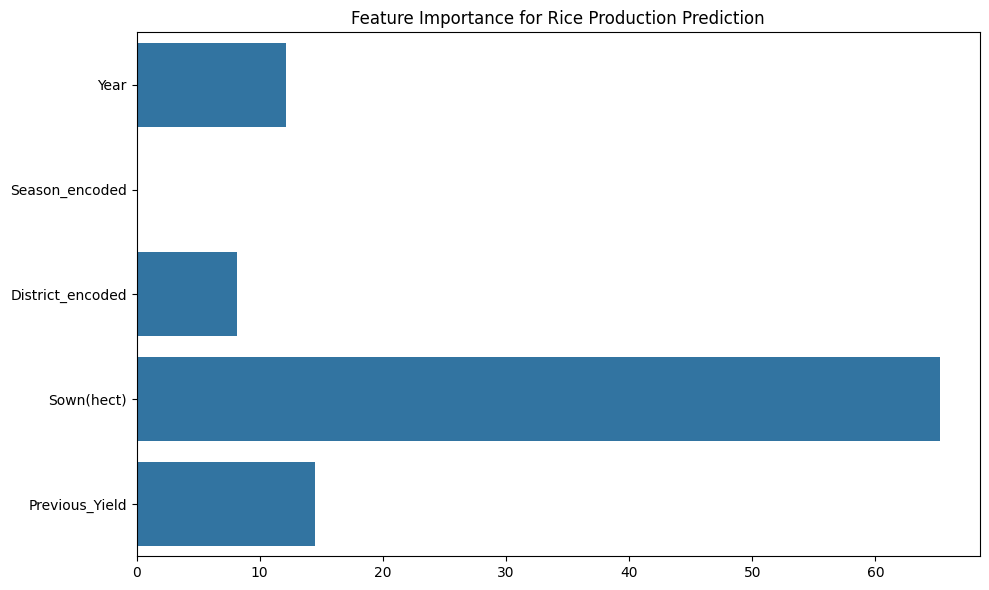

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model_extent.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance for Rice Production Prediction")
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import pandas as pd
from google.colab import files

# Load the saved models
# uploaded = files.upload()

# Load the Excel file (replace with the filename you uploaded)
# file_name = next(iter(uploaded))
# model_prediction = joblib.load("model_prediction.pkl")

# Static mappings (adjust if needed)
season_map = {'Maha': 0, 'Yala': 1}
district_list = df['District'].unique().tolist()

def predict_production(year, season, district, sown_hect, previous_yield):
    """
    Predict total rice production using pretrained models.
    Adjusts for unit conversion to match real-world production scale.

    Returns:
    - predicted_production_million_metric_tons
    - predicted_extent
    - predicted_yield
    """
    # Encode inputs
    season_encoded = season_map.get(season, 0)
    try:
        district_encoded = district_list.index(district.upper())
    except ValueError:
        raise ValueError(f"District '{district}' not found in the dataset.")

    # Create input DataFrame
    input_df = pd.DataFrame([{
        'Year': year,
        'Season_encoded': season_encoded,
        'District_encoded': district_encoded,
        'Sown(hect)': sown_hect,
        'Previous_Yield': previous_yield
    }])

    # Predict Harvested Extent
    predicted_extent = model_extent.predict(
        input_df[['Year', 'Season_encoded', 'District_encoded', 'Sown(hect)', 'Previous_Yield']]
    )[0]

    return round(predicted_extent, 2)

In [ ]:
extent = predict_production(
    year=1999,
    season='Yala',
    district='POLONNARUWA',
    sown_hect=46144,
    previous_yield=4335
    # year=1982,
    # season='Yala',
    # district='BADULLA',
    # sown_hect=4369
)

print(f"Predicted Harvested Extent: {extent} hectares")

Predicted Harvested Extent: 177200.0 hectares


In [ ]:
features1 = ['Year', 'Season_encoded', 'District_encoded', 'Extent Harvested(hect)', 'Previous_Yield']
target1 = 'Total production(mt.)'

# Drop rows with missing values in features or target
df_clean = df.dropna(subset=features + [target])

X = df_clean[features1]
y = df_clean[target1]

# Print the features used for training to verify
print("Features used for training model_prodiction:", features1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Features used for training model_prodiction: ['Year', 'Season_encoded', 'District_encoded', 'Extent Harvested(hect)', 'Previous_Yield']


In [ ]:
# Train model
model_prodiction = CatBoostRegressor(
    iterations=13600,
    depth=12,
    learning_rate=0.2,
    l2_leaf_reg=12,
    bagging_temperature=1,
    early_stopping_rounds=100,
    verbose=100,
    random_state=42
)

# model_prodiction = LGBMRegressor(
#    n_estimators=100,
#    max_depth=10,
#    learning_rate=0.1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    random_state=42
# )

# model_prodiction = XGBRegressor(
#    n_estimators=100,
#    max_depth=10,
#    learning_rate=0.1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    random_state=42
# )

# model_prodiction = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=30,
#     min_samples_leaf=1,
#     min_samples_split=2,
#     random_state=42
# )

model_prodiction.fit(X_train, y_train)

# Save models and mappings
joblib.dump(model_prodiction, "model_prodiction.pkl")
# Download from Colab
# files.download("model_prodiction.pkl")

0:	learn: 55308.2054177	total: 91.7ms	remaining: 20m 46s
100:	learn: 4027.1412584	total: 4.1s	remaining: 9m 7s
200:	learn: 2425.0194385	total: 6.69s	remaining: 7m 25s
300:	learn: 1555.3225306	total: 9.39s	remaining: 6m 55s
400:	learn: 1125.4016357	total: 12.1s	remaining: 6m 38s
500:	learn: 816.4775438	total: 16.1s	remaining: 7m
600:	learn: 629.7386836	total: 19.1s	remaining: 6m 53s
700:	learn: 479.1518841	total: 22s	remaining: 6m 45s
800:	learn: 371.9720321	total: 24.9s	remaining: 6m 37s
900:	learn: 296.7494693	total: 28.3s	remaining: 6m 38s
1000:	learn: 237.5639795	total: 32s	remaining: 6m 42s
1100:	learn: 192.7701645	total: 34.8s	remaining: 6m 34s
1200:	learn: 158.6516360	total: 37.6s	remaining: 6m 27s
1300:	learn: 128.9512518	total: 40.4s	remaining: 6m 21s
1400:	learn: 105.6997903	total: 44.7s	remaining: 6m 29s
1500:	learn: 84.9211446	total: 47.5s	remaining: 6m 22s
1600:	learn: 68.2995392	total: 50.3s	remaining: 6m 17s
1700:	learn: 55.3390847	total: 53.1s	remaining: 6m 11s
1800:	lea

['model_prodiction.pkl']

In [ ]:
y_pred = model_prodiction.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 7173.823676450042
R² Score: 0.9556888960092496


In [ ]:
import joblib
import pandas as pd
from google.colab import files

# Load the saved production model
# Assuming the model_prodiction.pkl is already uploaded or saved to the Colab environment
try:
    model_prodiction = joblib.load("model_prodiction.pkl")
except FileNotFoundError:
    print("model_prodiction.pkl not found. Please ensure the model is saved and accessible.")
    # You might want to add a mechanism to upload the file here if it's not found

# Static mappings (adjust if needed)
season_map = {'Maha': 0, 'Yala': 1}
district_list = df['District'].unique().tolist()

def predict_production1(year, season, district, extent_hect, previous_yield):
    """
    Predict total rice production using pretrained models.
    Adjusts for unit conversion to match real-world production scale.

    Returns:
    - predicted_production_million_metric_tons
    - predicted_extent
    - predicted_yield
    """
    # Encode inputs
    season_encoded = season_map.get(season, 0)
    try:
        district_encoded = district_list.index(district.upper())
    except ValueError:
        raise ValueError(f"District '{district}' not found in the dataset.")

    # Create input DataFrame with correct feature names
    input_df = pd.DataFrame([{
        'Year': year,
        'Season_encoded': season_encoded,
        'District_encoded': district_encoded,
        'Extent Harvested(hect)': extent_hect,
        'Previous_Yield': previous_yield # Use the correct feature name
    }])

    # Predict Harvested Production
    predicted_production = model_prodiction.predict(
        input_df[['Year', 'Season_encoded', 'District_encoded', 'Extent Harvested(hect)', 'Previous_Yield']] # Use the correct feature names
    )[0]

    return round(predicted_production, 2)

In [ ]:
production = predict_production1(
    year=1999,
    season='Yala',
    district='POLONNARUWA',
    extent_hect=extent,
    previous_yield=4335
    # year=1982,
    # season='Yala',
    # district='BADULLA',
    # sown_hect=4369
)
print(f"extent: {extent}")
print(f"Predicted Harvested Extent: {production} hectares")

extent: 45813.0
Predicted Harvested Extent: 177200.0 hectares


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Load your test set
# Make sure your test_df has the necessary columns
# test_df = pd.read_csv("your_test_data.csv")

# Step 2: Predict extent and yield
X_extent_harvested = df[['Year', 'Season_encoded', 'District_encoded', 'Sown(hect)', 'Previous_Yield']]

df['Predicted_Production'] = model_extent.predict(X_extent_harvested)

# # Step 3: Predict final production using predicted extent
# X_final = df[['Year', 'Season_encoded', 'District_encoded', 'Previous_Yield']].copy()
# X_final['Extent Harvested(hect)'] = df['Predicted_Extent']

# df['Predicted_Production'] = model_prodiction.predict(X_final)

# Step 4: Evaluate predictions
y_true = df['Total production(mt.)']
y_pred = df['Predicted_Production']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f" Evaluation on Test Set:")
print(f" MAE: {mae:.2f}")
print(f" RMSE: {rmse:.2f}")
print(f" R²: {r2:.4f}")

 Evaluation on Test Set:
 MAE: 1802.46
 RMSE: 7559.09
 R²: 0.9859


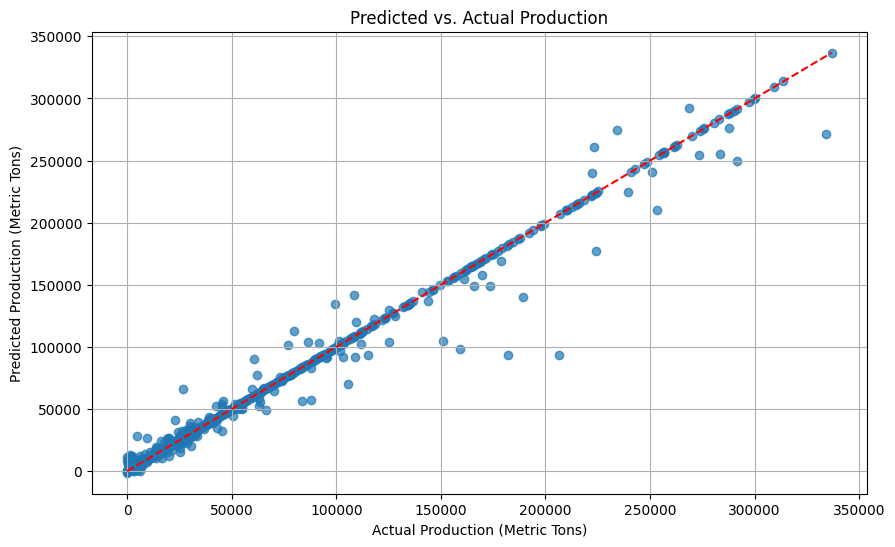

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect line
plt.xlabel("Actual Production (Metric Tons)")
plt.ylabel("Predicted Production (Metric Tons)")
plt.title("Predicted vs. Actual Production")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

In [ ]:
# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Use MAE for optimization
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# Fit on training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
# Get the best model and parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
y_pred_best = best_model.predict(X_test)
print("MAE (Tuned):", mean_absolute_error(y_test, y_pred_best))
print("R² Score (Tuned):", r2_score(y_test, y_pred_best))

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE (Tuned): 15.14854741887905
R² Score (Tuned): 0.9871879171897784


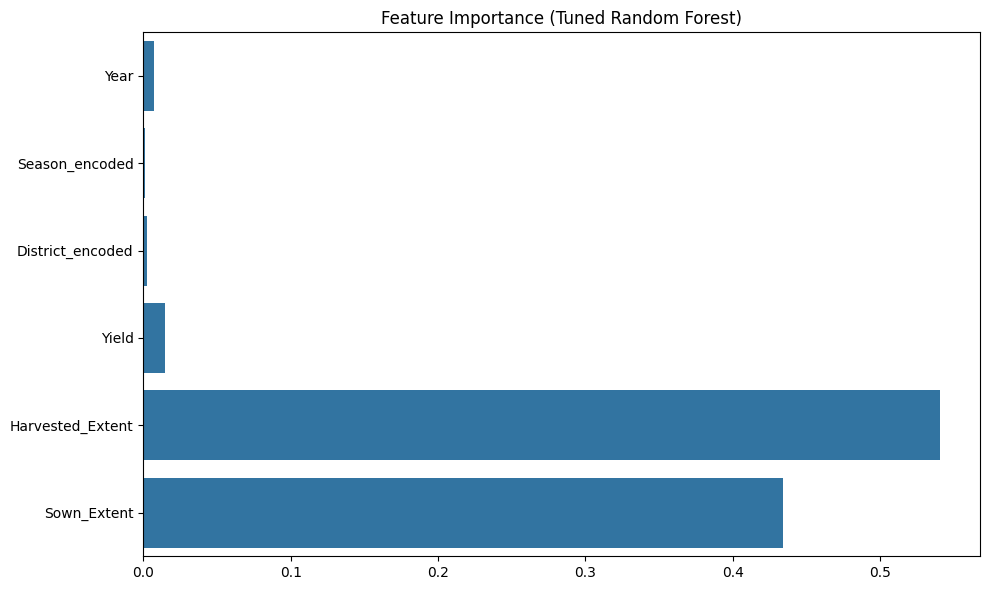

In [ ]:
importances = best_model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Tuned Random Forest)")
plt.tight_layout()
plt.show()

🔍 Tuned Model Performance:
MAE: 15.1485
R² Score: 0.987188


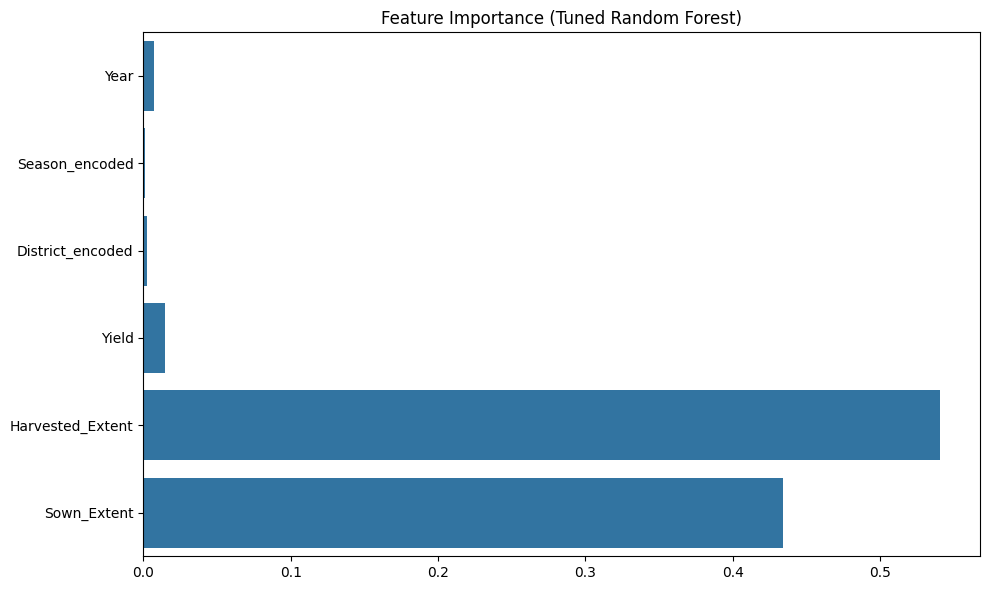

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train new model with best parameters
best_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

best_model.fit(X_train, y_train)

# Predict using the tuned model
y_pred_best = best_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print("🔍 Tuned Model Performance:")
print("MAE:", round(mae, 4))
print("R² Score:", round(r2, 6))

# Feature importance plot
importances = best_model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Tuned Random Forest)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load the Excel file (replace with the filename you uploaded)
df = pd.read_excel('/path/to/your/excel/file.xlsx')
df.head()